In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 15 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.53 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 595 µs


### Database ERD

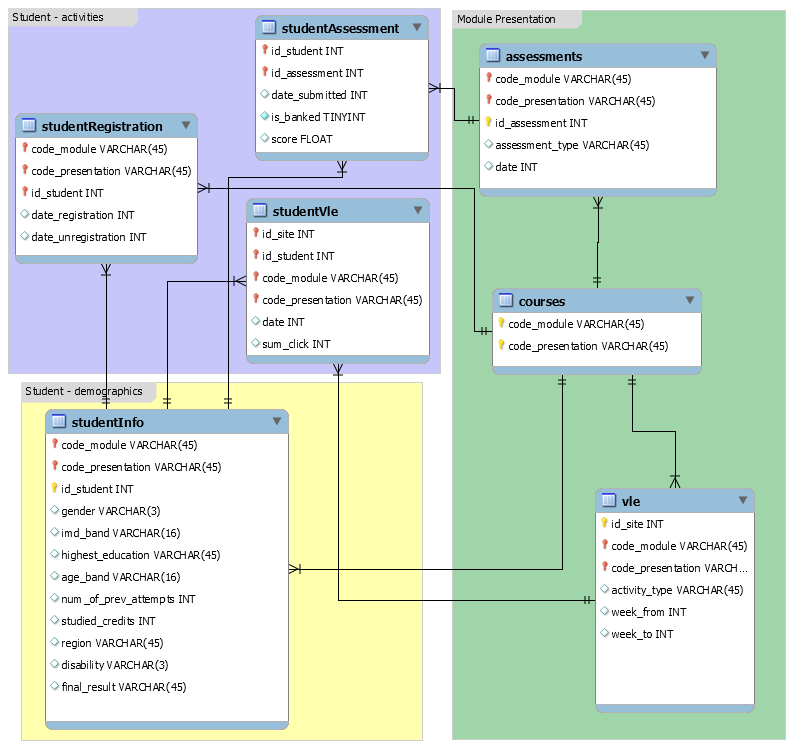

time: 3.79 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.52 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.43 ms


# STUDENTINFO Data

In [8]:
db.table_info('STUDENTINFO')

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'TEXT', 0, None, 0),
 (3, 'gender', 'TEXT', 0, None, 0),
 (4, 'region', 'TEXT', 0, None, 0),
 (5, 'highest_education', 'TEXT', 0, None, 0),
 (6, 'imd_band', 'TEXT', 0, None, 0),
 (7, 'age_band', 'TEXT', 0, None, 0),
 (8, 'num_of_prev_attempts', 'TEXT', 0, None, 0),
 (9, 'studied_credits', 'TEXT', 0, None, 0),
 (10, 'disability', 'TEXT', 0, None, 0),
 (11, 'final_result', 'TEXT', 0, None, 0)]

time: 4.04 ms


## Creating STUDENTINFO Data Frame

In [327]:
df = db.student_info()

time: 175 ms


In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  object
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  object
 9   studied_credits       32593 non-null  object
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
 12  row_id                32593 non-null  object
 13  target                32593 non-null  int64 
dtypes: int64(1), object(13)
memory usage: 3.5+ MB
time: 26.4 ms


In [329]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,row_id,target
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,AAA2013J11391,0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,AAA2013J28400,0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,AAA2013J30268,1
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,AAA2013J31604,0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,AAA2013J32885,0


time: 10.1 ms


In [330]:
df = db.sql_fixes(df)

time: 44.3 ms


In [331]:
drops = ['row_id', 'code_module', 'code_presentation',
         'id_student', 'final_result', 'studied_credits']

time: 806 µs


In [332]:
df = db.pipe_cleaner(df, drops)

time: 60.7 ms


In [333]:
df.target.value_counts(normalize=True)

1    0.531724
0    0.468276
Name: target, dtype: float64

time: 4.18 ms


In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31144 entries, 1 to 32592
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                31144 non-null  int64   
 1   gender                31144 non-null  object  
 2   region                31144 non-null  object  
 3   highest_education     31144 non-null  object  
 4   imd_band              31144 non-null  object  
 5   age_band              31144 non-null  object  
 6   num_of_prev_attempts  31144 non-null  object  
 7   disability            31144 non-null  object  
 8   course_load           31144 non-null  category
dtypes: category(1), int64(1), object(7)
memory usage: 2.2+ MB
time: 16.7 ms


## Creating Holdout Data

In [335]:
# splitting data & target
X, y = f.X_y(df)

time: 4.23 ms


In [336]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 15.1 ms


## Creating Training Data

In [337]:
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 11.4 ms


## Baseline Model: Dummy Classifier

In [338]:
dummy = DummyClassifier(strategy='most_frequent')

time: 718 µs


In [339]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 778 µs


### Fitting Model

In [340]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 55.1 ms


### Saving Model

In [341]:
# f.pickle_model(baseline, 'baseline')

time: 594 µs


### Cross Val Scores

In [342]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.5317387933630273
 Baseline has an average F1 of 0.6942943448460349
 Baseline has an average Recall of 1.0
 Baseline has an average Precision of 0.5317387933630273
time: 271 ms


### Test Data Confusion Matrix

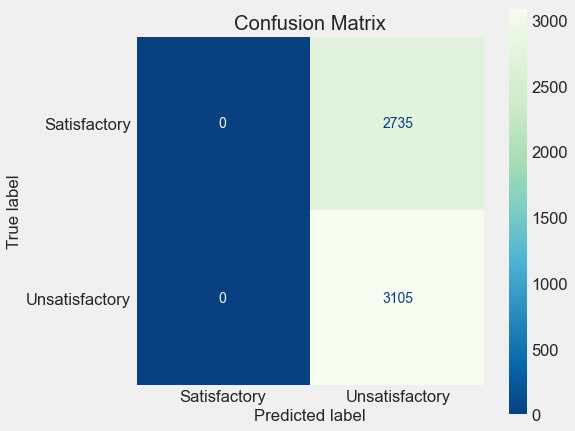

,Accuracy,F1,Recall,Precision
0,0.531678,0.694243,1.0,0.531678


time: 317 ms


In [343]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [344]:
mnb = MultinomialNB()

time: 700 µs


In [345]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 1.06 ms


### Fitting Model

In [346]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>)])),
                ('multinomialnb', MultinomialNB())])

time: 52.5 ms


### Saving Model

In [347]:
# f.pickle_model(fsm, 'fsm')

time: 599 µs


### Cross Val Scores

In [348]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.5916768014891345
 fsm has an average F1 of 0.6322452250401034
 fsm has an average Recall of 0.6601180891035965
 fsm has an average Precision of 0.6066617559420104
time: 289 ms


### Test Data Confusion Matrix

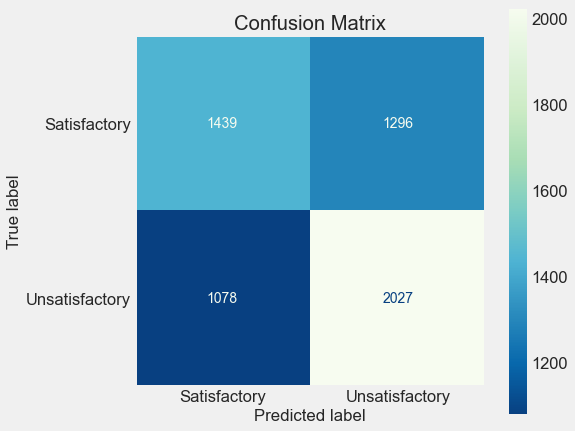

,Accuracy,F1,Recall,Precision
0,0.593493,0.630678,0.652818,0.609991


time: 316 ms


In [349]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

## KNeighborsClassifier

In [350]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 746 µs


In [33]:
knn = make_pipeline(preprocessing_ohe, KNN)

time: 1.03 ms


### Fitting Model

In [34]:
knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 56.5 ms


In [35]:
# f.pickle_model(knn, 'knn')

time: 786 µs


### Cross Val Scores

In [36]:
# checking cross val scores
modeling.report(knn, X_train, y_train, 'knn', 'KNN')

knn has an average Accuracy of 0.5476089151242836
knn has an average F1 of 0.5820768181323872
knn has an average Recall of 0.5925925925925926
knn has an average Precision of 0.5719650224760784
time: 9.38 s


### Test Data Confusion Matrix

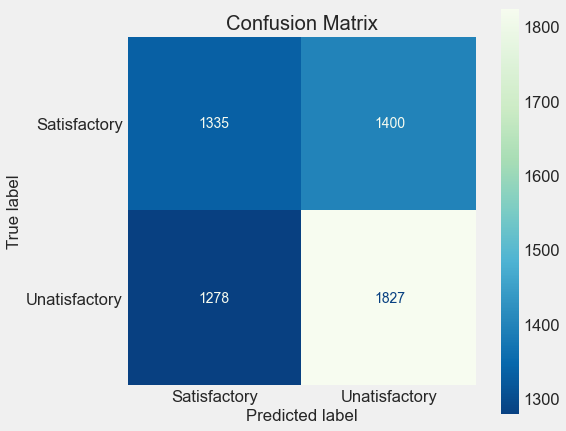

,Accuracy,F1,Recall,Precision
0,0.541438,0.577069,0.588406,0.566161


time: 20.3 s


In [37]:
f.confusion_report(knn, X_test, y_test)

## Logistic Regression Classifier

In [38]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 851 µs


In [39]:
logreg = make_pipeline(preprocessing_ohe, LR)

time: 1.04 ms


### Fitting Model

In [40]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 4.44 s


In [41]:
# f.pickle_model(logreg, 'logreg')

time: 1.29 ms


### Cross Val Scores

In [42]:
# checking cross val scores
modeling.report(logreg, X_train, y_train, 'logreg', 'Logistic Regression')

logreg has an average Accuracy of 0.5959580144611859
logreg has an average F1 of 0.6378999205930793
logreg has an average Recall of 0.6694578636607622
logreg has an average Precision of 0.6092986437167408
time: 3.01 s


### Test Data Confusion Matrix

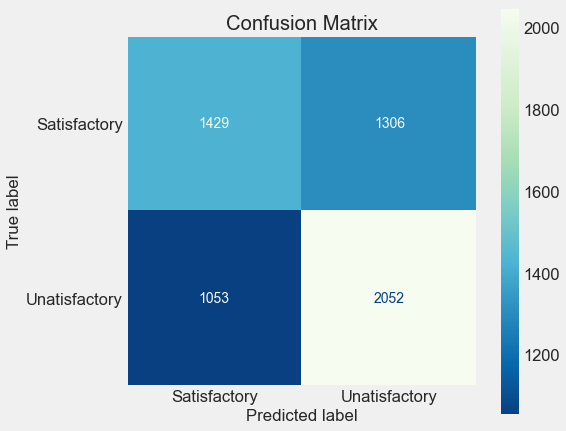

,Accuracy,F1,Recall,Precision
0,0.596062,0.634999,0.66087,0.611078


time: 270 ms


In [43]:
f.confusion_report(logreg, X_test, y_test)

## Support Vector Machine

In [44]:
SVC = SVC()

time: 971 µs


In [45]:
svc = make_pipeline(preprocessing_ohe, SVC)

time: 930 µs


### Fitting Model

In [46]:
svc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>)])),
                ('svc', SVC())])

time: 17 s


In [47]:
# f.pickle_model(svc, 'svc')

time: 726 µs


### Cross Val Scores

In [48]:
# checking cross val scores
modeling.report(svc, X_train, y_train, 'svc', 'Support Vector Classifier')

svc has an average Accuracy of 0.5928756271532423
svc has an average F1 of 0.6390935516080927
svc has an average Recall of 0.6786902844873859
svc has an average Precision of 0.6043848514837592
time: 1min 4s


### Test Data Confusion Matrix

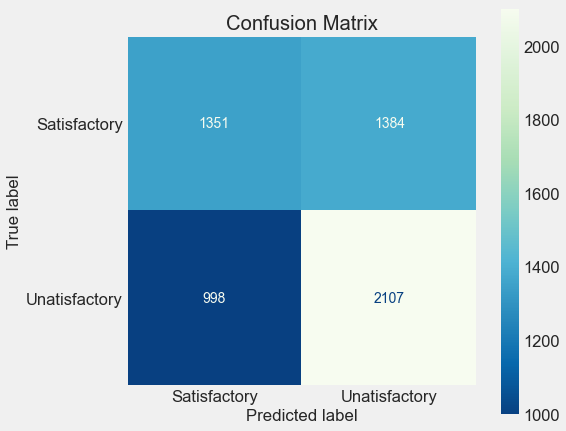

,Accuracy,F1,Recall,Precision
0,0.592123,0.638872,0.678583,0.603552


time: 20.4 s


In [49]:
f.confusion_report(svc, X_test, y_test)

## Linear Support Vector Machine

In [50]:
LSVC = LinearSVC()

time: 744 µs


In [51]:
lsvc = make_pipeline(preprocessing_ohe, LSVC)

time: 896 µs


### Fitting Model

In [52]:
lsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>)])),
                ('linearsvc', LinearSVC())])

time: 304 ms


In [53]:
# f.pickle_model(lsvc, 'lsvc')

time: 900 µs


### Cross Val Scores

In [54]:
# checking cross val scores
modeling.report(lsvc, X_train, y_train, 'lsvc', 'Linear SVC')

lsvc has an average Accuracy of 0.5960721860062542
lsvc has an average F1 of 0.6378643542264031
lsvc has an average Recall of 0.6691358024691357
lsvc has an average Precision of 0.6094955875821146
time: 1.01 s


### Test Data Confusion Matrix

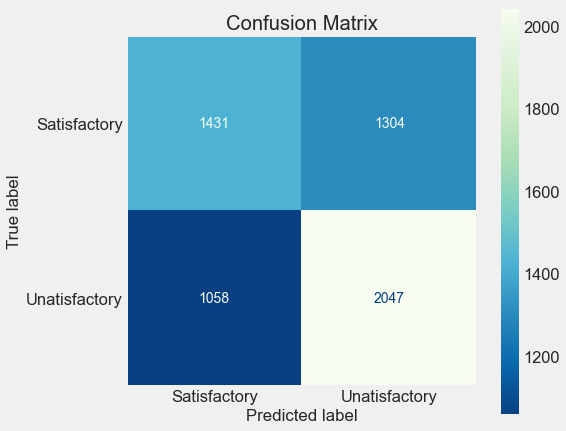

,Accuracy,F1,Recall,Precision
0,0.595548,0.634139,0.659259,0.610862


time: 242 ms


In [55]:
f.confusion_report(lsvc, X_test, y_test)

## Decision Tree

In [56]:
DT = DecisionTreeClassifier(random_state=2021)

time: 819 µs


In [57]:
dt = make_pipeline(preprocessing_ohe, DT)

time: 1.02 ms


### Fitting Model

In [58]:
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 296 ms


In [59]:
# f.pickle_model(dt, 'dt')

time: 692 µs


### Cross Val Scores

In [60]:
# checking cross val scores
modeling.report(dt, X_train, y_train, 'dt', 'Decision Tree')

dt has an average Accuracy of 0.5506333123467557
dt has an average F1 of 0.5622212347365302
dt has an average Recall of 0.5427804616210412
dt has an average Precision of 0.5832053074895044
time: 1.12 s


### Test Data Confusion Matrix

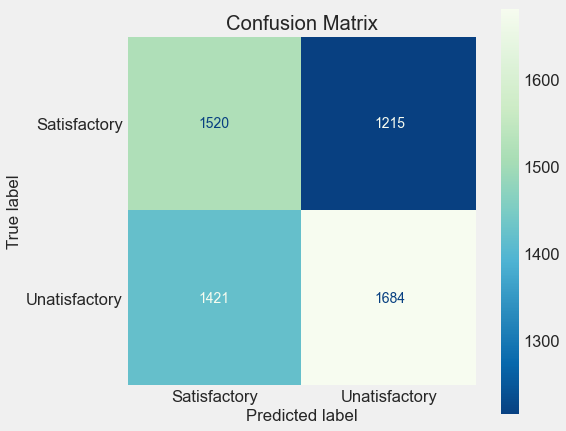

,Accuracy,F1,Recall,Precision
0,0.54863,0.560959,0.542351,0.58089


time: 268 ms


In [61]:
f.confusion_report(dt, X_test, y_test)

## Bagging Classifier

In [62]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 899 µs


In [63]:
bclf = make_pipeline(preprocessing_ohe, BCLF)

time: 1.03 ms


### Fitting Model

In [64]:
bclf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 1.97 s


In [65]:
# f.pickle_model(bclf, 'bclf')

time: 652 µs


### Cross Val Scores

In [66]:
# checking cross val scores
modeling.report(bclf, X_train, y_train, 'bclf', 'Bagging CLF')

bclf has an average Accuracy of 0.5514896885513656
bclf has an average F1 of 0.5890398847657412
bclf has an average Recall of 0.6045088566827698
bclf has an average Precision of 0.5743717386752488
time: 7.21 s


### Test Data Confusion Matrix

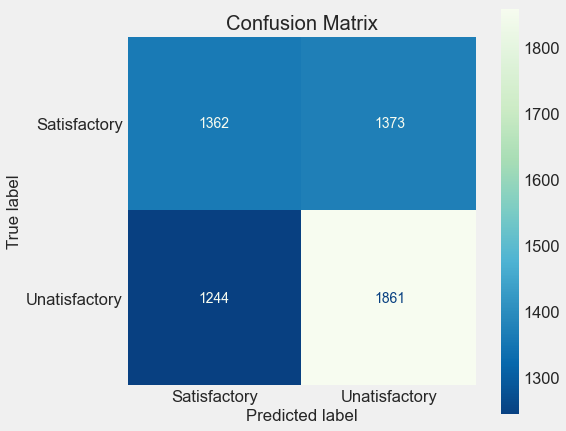

,Accuracy,F1,Recall,Precision
0,0.551884,0.587159,0.599356,0.575448


time: 329 ms


In [67]:
f.confusion_report(bclf, X_test, y_test)

## Random Forest Classifier

In [68]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 951 µs


In [69]:
rf = make_pipeline(preprocessing_ohe, RF)

time: 1.38 ms


### Fitting Model

In [70]:
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.78 s


In [71]:
# f.pickle_model(rf, 'rf')

time: 622 µs


### Cross Val Scores

In [72]:
# checking cross val scores
modeling.report(rf, X_train, y_train, 'rf', 'Random Forest')

rf has an average Accuracy of 0.5581683573245112
rf has an average F1 of 0.5972251059962846
rf has an average Recall of 0.6161030595813204
rf has an average Precision of 0.5795256602352586
time: 14.2 s


### Test Data Confusion Matrix

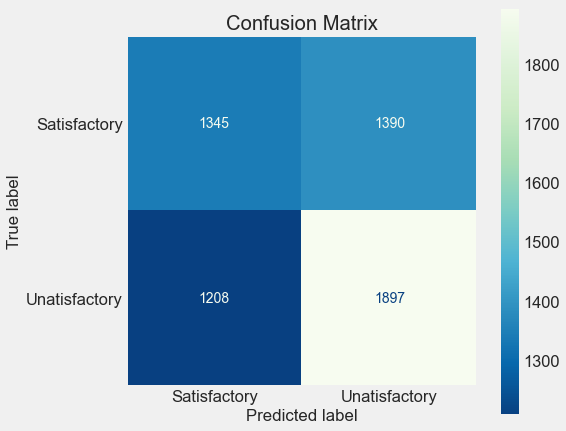

,Accuracy,F1,Recall,Precision
0,0.555137,0.593554,0.61095,0.577122


time: 601 ms


In [73]:
f.confusion_report(rf, X_test, y_test)

## AdaBoost

In [74]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 874 µs


In [75]:
ada = make_pipeline(preprocessing_ohe, ADA)

time: 1.13 ms


### Fitting Model

In [76]:
ada.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 1.62 s


In [77]:
# f.pickle_model(ada, 'ada')

time: 618 µs


### Cross Val Scores

In [78]:
# checking cross val scores
modeling.report(ada, X_train, y_train, 'ada', 'AdaBoost')

ada has an average Accuracy of 0.5533165962117271
ada has an average F1 of 0.5919711692314908
ada has an average Recall of 0.6093397745571659
ada has an average Precision of 0.5756395940493289
time: 6.29 s


### Test Data Confusion Matrix

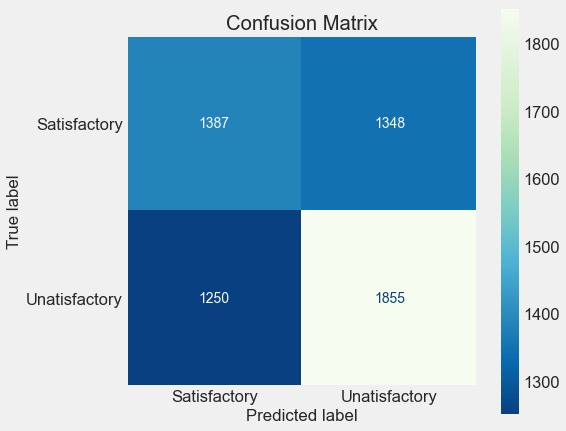

,Accuracy,F1,Recall,Precision
0,0.555137,0.588142,0.597424,0.579145


time: 458 ms


In [79]:
f.confusion_report(ada, X_test, y_test)

## XGBoost

In [80]:
XGB = XGBClassifier(use_label_encoder=False)

time: 913 µs


In [81]:
xgb = make_pipeline(preprocessing_ohe, XGB)

time: 1.23 ms


### Fitting Model

In [82]:
%%capture --no-display
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               impo...pe='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
            

time: 737 ms


In [83]:
# f.pickle_model(xgb, 'xgb')

time: 886 µs


### Cross Val Scores

In [84]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb, X_train, y_train, 'xgb', 'XGBoost')

time: 2.95 s


### Test Data Confusion Matrix

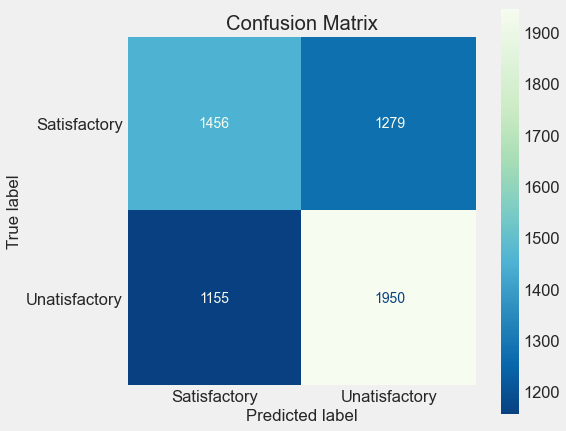

,Accuracy,F1,Recall,Precision
0,0.583219,0.615725,0.628019,0.603902


time: 453 ms


In [85]:
%%capture --no-display
f.confusion_report(xgb, X_test, y_test)

## Model Summary 1

In [86]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.694294,1.000000,0.531739,0.320701,Baseline DummyCFL
1,knn,0.547609,0.582077,0.592593,0.571965,9.371466,KNN
2,dt,0.550633,0.562221,0.542780,0.583205,1.117002,Decision Tree
3,bclf,0.551490,0.589040,0.604509,0.574372,7.211194,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.283309,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,14.178439,Random Forest
10,xgb,0.577863,0.615289,0.635105,0.596842,2.940607,XGBoost
6,fsm,0.591677,0.632245,0.660118,0.606662,0.318320,FSM Naive Bayes
7,svc,0.592876,0.639094,0.678690,0.604385,64.482871,Support Vector Classifier
8,logreg,0.595958,0.637900,0.669458,0.609299,3.004439,Logistic Regression


time: 11.5 ms


# Adding STUDENTVLE Features
<font size=4>(click_sum, num_activities)</font>

In [87]:
df = db.sv_si()

time: 38.5 s


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29228 entries, 0 to 29227
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                29228 non-null  int64   
 1   row_id                29228 non-null  object  
 2   code_module           29228 non-null  object  
 3   code_presentation     29228 non-null  object  
 4   id_student            29228 non-null  object  
 5   id_site               29228 non-null  object  
 6   date                  29228 non-null  object  
 7   sum_click             29228 non-null  object  
 8   gender                29228 non-null  object  
 9   region                29228 non-null  object  
 10  highest_education     29228 non-null  object  
 11  imd_band              28174 non-null  object  
 12  age_band              29228 non-null  object  
 13  num_of_prev_attempts  29228 non-null  int64   
 14  studied_credits       29228 non-null  int64   
 15  di

In [89]:
drops = ['row_id', 'code_module', 'code_presentation', 'studied_credits',
         'id_student', 'id_site', 'date', 'sum_click', 'final_result']

time: 1.26 ms


In [90]:
df = db.pipe_cleaner(df, drops)

time: 87.6 ms


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26470 entries, 0 to 29227
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                26470 non-null  int64   
 1   gender                26470 non-null  object  
 2   region                26470 non-null  object  
 3   highest_education     26470 non-null  object  
 4   imd_band              26470 non-null  object  
 5   age_band              26470 non-null  object  
 6   num_of_prev_attempts  26470 non-null  int64   
 7   disability            26470 non-null  object  
 8   click_sum             26470 non-null  int64   
 9   num_activities        26470 non-null  int64   
 10  course_load           26470 non-null  category
dtypes: category(1), int64(4), object(6)
memory usage: 2.2+ MB
time: 18.5 ms


In [92]:
df.head()

,target,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,click_sum,num_activities,course_load
0,0,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,No,744,243,Light
1,0,Male,South Region,Lower Than A Level,80-90%,35-55,0,No,4104,913,Light
2,0,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,No,1944,781,Light
3,0,Male,London Region,HE Qualification,60-70%,0-35,0,No,1150,313,Light
4,0,Female,London Region,Lower Than A Level,30-40%,35-55,0,No,1896,572,Light


time: 13.3 ms


In [93]:
df.describe()

,target,num_of_prev_attempts,click_sum,num_activities
count,26470.000000,26470.000000,26470.000000,26470.000000
mean,0.469890,0.144125,1338.822629,360.084133
std,0.499102,0.452979,1719.149524,375.345601
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,259.000000,93.000000
50%,0.000000,0.000000,731.500000,239.000000
75%,1.000000,0.000000,1740.000000,500.000000
max,1.000000,6.000000,24139.000000,2953.000000


time: 19.7 ms


## Creating Holdout Data

In [94]:
# splitting data & target
X, y = f.X_y(df)

time: 5.44 ms


In [95]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 20.3 ms


## Creating Training Data

In [96]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 18.8 ms


## MinMax Scaling
Since we've added numerical columns with very different scales to the data, we'll implement some scaling in the pipeline. K-Nearest Neighbors in particular is sensitive to differences in feature scale, and scaling can also help speed up convergence is certain algorithms.

## Naive Bayes Classifier

In [97]:
mnb_svsi = make_pipeline(preprocessing_mm, mnb)

time: 948 µs


### Fitting Model

In [98]:
mnb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('multinomialnb', MultinomialNB())])

time: 78.4 ms


### Saving Model

In [99]:
# f.pickle_model(mnb_svsi, 'mnb_svsi')

time: 710 µs


### Cross Val Scores

In [100]:
# checking cross val scores
modeling.report(mnb_svsi, X_train, y_train, ' mnb_svsi',\
                'Naive Bayes SVSI/MinMax()')

 mnb_svsi has an average Accuracy of 0.6511515529965238
 mnb_svsi has an average F1 of 0.6004921499760085
 mnb_svsi has an average Recall of 0.5580313489226999
 mnb_svsi has an average Precision of 0.6499920377587581
time: 380 ms


### Test Data Confusion Matrix

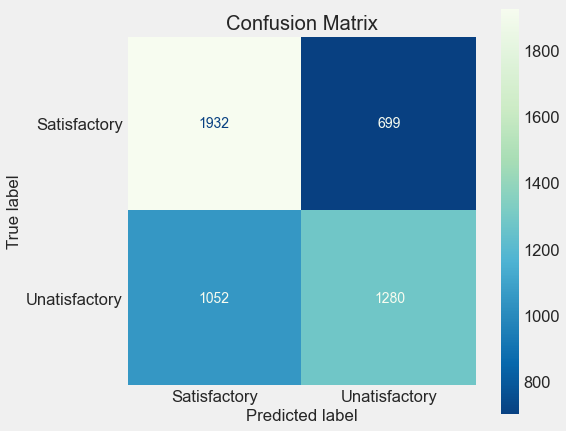

,Accuracy,F1,Recall,Precision
0,0.647189,0.59383,0.548885,0.646791


time: 278 ms


In [101]:
f.confusion_report(mnb_svsi, X_test, y_test)

## KNeighborsClassifier

In [102]:
knn_svsi = make_pipeline(preprocessing_mm, KNN)

time: 921 µs


### Fitting Model

In [103]:
knn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 81 ms


In [104]:
# f.pickle_model(knn_svsi, 'knn_svsi')

time: 730 µs


### Cross Val Scores

In [105]:
# checking cross val scores
modeling.report(knn_svsi, X_train, y_train, 'knn_svsi',\
                'KNN SVSI/MinMax()')

knn_svsi has an average Accuracy of 0.6838607745570304
knn_svsi has an average F1 of 0.6586426638627266
knn_svsi has an average Recall of 0.6490860818952313
knn_svsi has an average Precision of 0.6684974392837131
time: 7.77 s


### Test Data Confusion Matrix

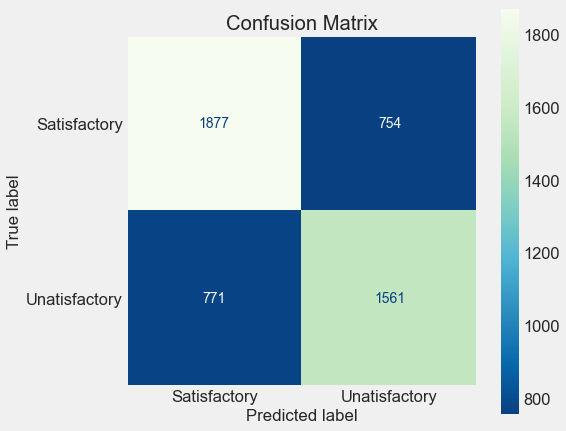

,Accuracy,F1,Recall,Precision
0,0.692726,0.671831,0.669383,0.674298


time: 16 s


In [106]:
f.confusion_report(knn_svsi, X_test, y_test)

## Logistic Regression Classifier

In [107]:
logreg_svsi = make_pipeline(preprocessing_mm, LR)

time: 928 µs


### Fitting Model

In [108]:
logreg_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 268 ms


In [109]:
# f.pickle_model(logreg_svsi, 'logreg_svsi')

time: 775 µs


### Cross Val Scores

In [110]:
# checking cross val scores
modeling.report(logreg_svsi, X_train, y_train, 'logreg_svsi',\
                'LogReg SVSI/MinMax()')

logreg_svsi has an average Accuracy of 0.7752698153946318
logreg_svsi has an average F1 of 0.7713370572078657
logreg_svsi has an average Recall of 0.806604002859185
logreg_svsi has an average Precision of 0.7391091970077099
time: 990 ms


### Test Data Confusion Matrix

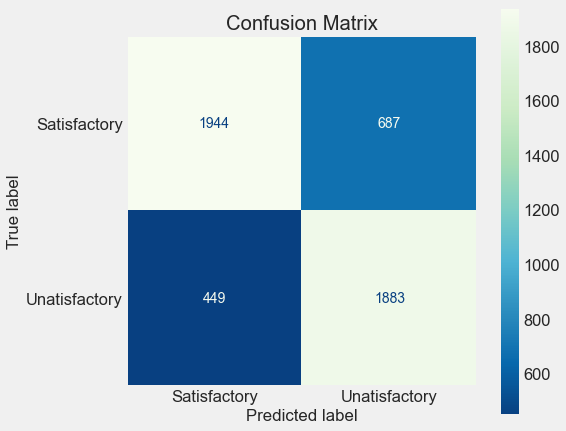

,Accuracy,F1,Recall,Precision
0,0.771106,0.768258,0.807461,0.732685


time: 285 ms


In [111]:
f.confusion_report(logreg_svsi, X_test, y_test)

## Support Vector Machine

In [112]:
svc_svsi= make_pipeline(preprocessing_mm, SVC)

time: 1.25 ms


### Fitting Model

In [113]:
svc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('svc', SVC())])

time: 10.5 s


In [114]:
# f.pickle_model(svc, 'svc_svsi')

time: 928 µs


### Cross Val Scores

In [115]:
# checking cross val scores
modeling.report(svc_svsi, X_train, y_train, 'svc_svsi',\
                'Support Vector CLF SVSI/MinMax()')

svc_svsi has an average Accuracy of 0.7586804182412148
svc_svsi has an average F1 of 0.755314293594922
svc_svsi has an average Recall of 0.7925952210762789
svc_svsi has an average Precision of 0.7214731939685197
time: 45.4 s


### Test Data Confusion Matrix

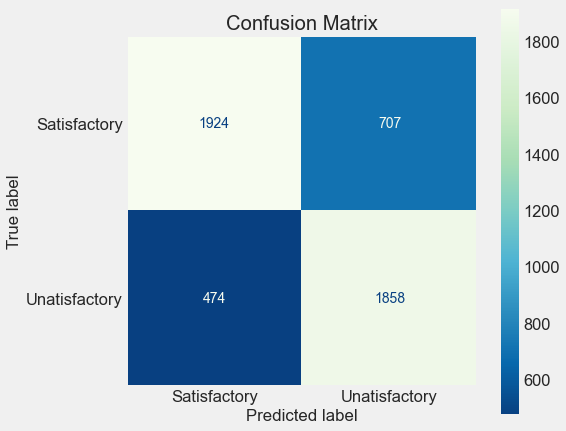

,Accuracy,F1,Recall,Precision
0,0.762039,0.758832,0.796741,0.724366


time: 15.3 s


In [116]:
f.confusion_report(svc_svsi, X_test, y_test)

## Linear Support Vector Machine

In [117]:
lsvc_svsi = make_pipeline(preprocessing_mm, LSVC)

time: 1.21 ms


### Fitting Model

In [118]:
lsvc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('linearsvc', LinearSVC())])

time: 292 ms


In [119]:
# f.pickle_model(lsvc_svsi, 'lsvc_svsi')

time: 1.25 ms


### Cross Val Scores

In [120]:
# checking cross val scores
modeling.report(lsvc_svsi, X_train, y_train, 'lsvc_svsi',\
                'Linear SVC SVSI/MinMax()')

lsvc_svsi has an average Accuracy of 0.7711732641092341
lsvc_svsi has an average F1 of 0.7707348320961438
lsvc_svsi has an average Recall of 0.818611048708261
lsvc_svsi has an average Precision of 0.728228844792579
time: 1.14 s


### Test Data Confusion Matrix

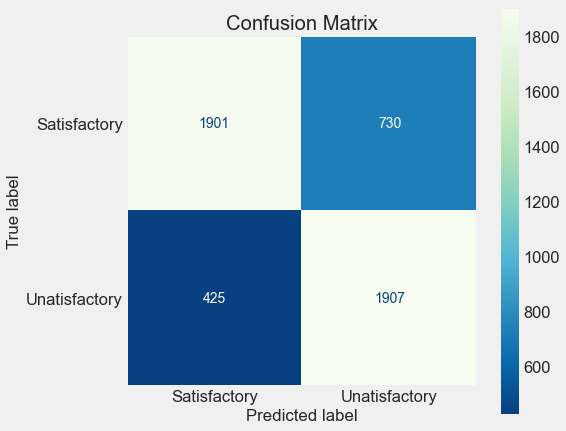

,Accuracy,F1,Recall,Precision
0,0.767278,0.767559,0.817753,0.72317


time: 301 ms


In [121]:
f.confusion_report(lsvc_svsi, X_test, y_test)

## Decision Tree

In [122]:
dt_svsi = make_pipeline(preprocessing_mm, DT)

time: 1.17 ms


### Fitting Model

In [123]:
dt_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 652 ms


In [124]:
# f.pickle_model(dt_svsi, 'dt_svsi')

time: 787 µs


### Cross Val Scores

In [125]:
# checking cross val scores
modeling.report(dt_svsi, X_train, y_train, 'dt_svsi',\
                'Decision Tree CLF SVSI/MinMax()')

dt_svsi has an average Accuracy of 0.713815725802904
dt_svsi has an average F1 of 0.6972835816297781
dt_svsi has an average Recall of 0.7015451853364648
dt_svsi has an average Precision of 0.6931909683478993
time: 2.88 s


### Test Data Confusion Matrix

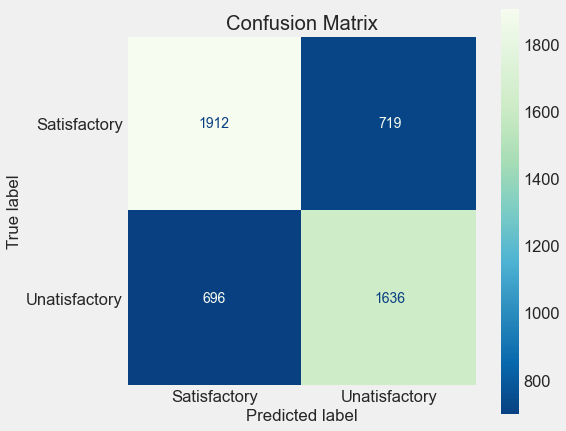

,Accuracy,F1,Recall,Precision
0,0.71489,0.698101,0.701544,0.694692


time: 297 ms


In [126]:
f.confusion_report(dt_svsi, X_test, y_test)

## Bagging Classifier

In [127]:
bclf_svsi = make_pipeline(preprocessing_mm, BCLF)

time: 1.29 ms


### Fitting Model

In [128]:
bclf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.25 s


In [129]:
# f.pickle_model(bclf_svsi, 'bclf_svsi')

time: 745 µs


### Cross Val Scores

In [130]:
# checking cross val scores
modeling.report(bclf_svsi, X_train, y_train, 'bclf_svsi',\
                'Bagging CLF SVSI/MinMax()')

bclf_svsi has an average Accuracy of 0.7640543472645553
bclf_svsi has an average F1 of 0.7292893009821926
bclf_svsi has an average Recall of 0.6765289492494639
bclf_svsi has an average Precision of 0.791078275378512
time: 17.4 s


### Test Data Confusion Matrix

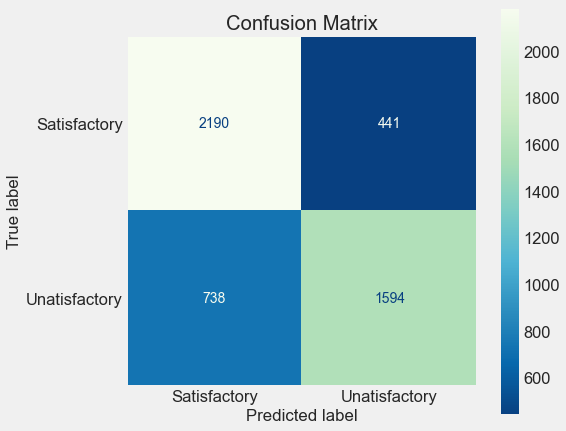

,Accuracy,F1,Recall,Precision
0,0.762442,0.730021,0.683533,0.783292


time: 467 ms


In [131]:
f.confusion_report(bclf_svsi, X_test, y_test)

## Random Forest Classifier

In [132]:
rf_svsi = make_pipeline(preprocessing_mm, RF)

time: 1.19 ms


### Fitting Model

In [133]:
rf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.94 s


In [134]:
# f.pickle_model(rf_svsi, 'rf_svsi')

time: 1.09 ms


### Cross Val Scores

In [135]:
# checking cross val scores
modeling.report(rf_svsi, X_train, y_train, 'rf_svsi',\
                'Random Forest SVSI/MinMax()')

rf_svsi has an average Accuracy of 0.7768826054598575
rf_svsi has an average F1 of 0.7498473690552829
rf_svsi has an average Recall of 0.7118373327887266
rf_svsi has an average Precision of 0.792230079562219
time: 12.1 s


### Test Data Confusion Matrix

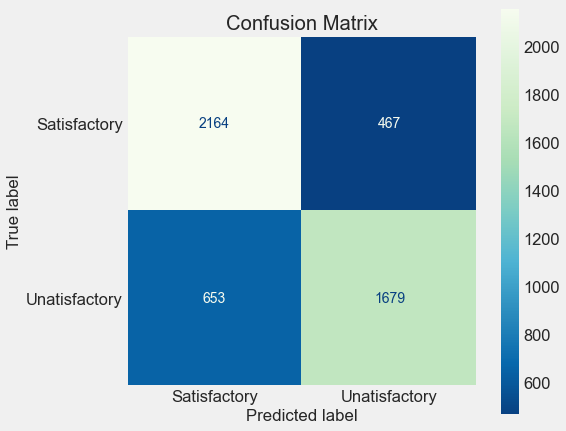

,Accuracy,F1,Recall,Precision
0,0.77433,0.749888,0.719983,0.782386


time: 613 ms


In [136]:
f.confusion_report(rf_svsi, X_test, y_test)

## AdaBoost

In [137]:
ada_svsi = make_pipeline(preprocessing_mm, ADA)

time: 1.28 ms


### Fitting Model

In [138]:
ada_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 632 ms


In [139]:
# f.pickle_model(ada_svsi, 'ada_svsi')

time: 705 µs


### Cross Val Scores

In [140]:
# checking cross val scores
modeling.report(ada_svsi, X_train, y_train, 'ada_svsi',\
                'AdaBoost SVSI/MinMax()')

ada_svsi has an average Accuracy of 0.7134796366952998
ada_svsi has an average F1 of 0.696720016390799
ada_svsi has an average Recall of 0.7005452874502195
ada_svsi has an average Precision of 0.6930858638492422
time: 2.14 s


### Test Data Confusion Matrix

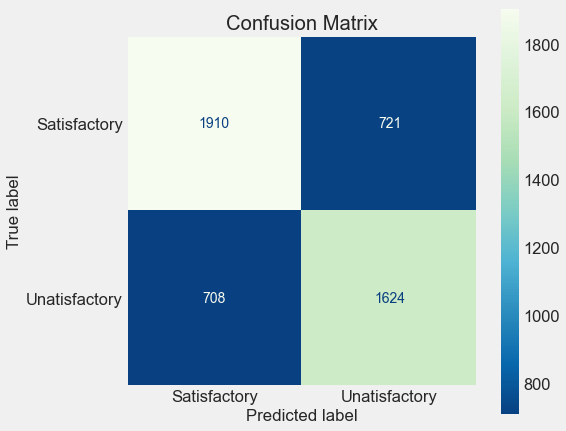

,Accuracy,F1,Recall,Precision
0,0.712069,0.694462,0.696398,0.692537


time: 332 ms


In [141]:
f.confusion_report(ada_svsi, X_test, y_test)

## XGBoost

In [142]:
xgb_svsi = make_pipeline(preprocessing_mm, XGB)

time: 976 µs


### Fitting Model

In [143]:
%%capture --no-display
xgb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.6 s


In [144]:
# f.pickle_model(xgb_svsi, 'xgb_svsi')

time: 735 µs


### Cross Val Scores

In [145]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_svsi, X_train, y_train, 'xgb_svsi',\
                'XGBoost SVSI/MinMax()')

time: 9.69 s


### Test Data Confusion Matrix

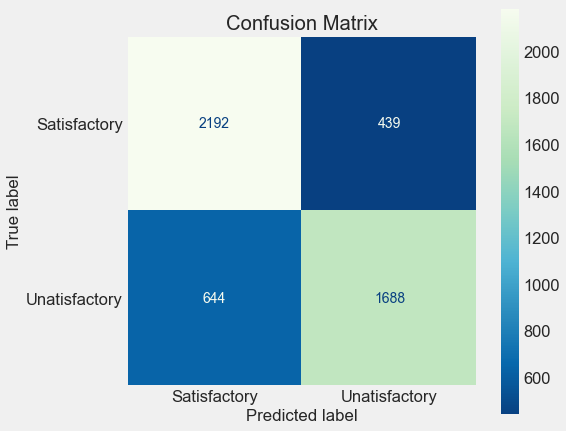

,Accuracy,F1,Recall,Precision
0,0.781785,0.75712,0.723842,0.793606


time: 592 ms


In [146]:
%%capture --no-display
f.confusion_report(xgb_svsi, X_test, y_test)

## Model Summary 2

In [147]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.694294,1.000000,0.531739,0.320701,Baseline DummyCFL
1,knn,0.547609,0.582077,0.592593,0.571965,9.371466,KNN
2,dt,0.550633,0.562221,0.542780,0.583205,1.117002,Decision Tree
3,bclf,0.551490,0.589040,0.604509,0.574372,7.211194,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.283309,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,14.178439,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.940607,XGBoost
7,fsm,0.591677,0.632245,0.660118,0.606662,0.318320,FSM Naive Bayes
8,svc,0.592876,0.639094,0.678690,0.604385,64.482871,Support Vector Classifier
9,logreg,0.595958,0.637900,0.669458,0.609299,3.004439,Logistic Regression


time: 20.4 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [148]:
clf1 = LR
clf2 = SVC
clf3 = XGB

estimators = [('logreg', clf1), ('scv', clf2), ('lsvc',clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.57 ms


In [149]:
vc_svsi = make_pipeline(preprocessing_mm, VC)

time: 1.35 ms


### Fitting Model

In [150]:
%%capture --no-display
vc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 14.4 s


In [151]:
# f.pickle_model(vc_svsi, 'vc_svsi')

time: 1.06 ms


### Cross Val Scores

In [152]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_svsi, X_train, y_train, 'vc_svsi',\
                'Voting CLF SVSI/MinMax()')

time: 46.7 s


### Test Data Confusion Matrix

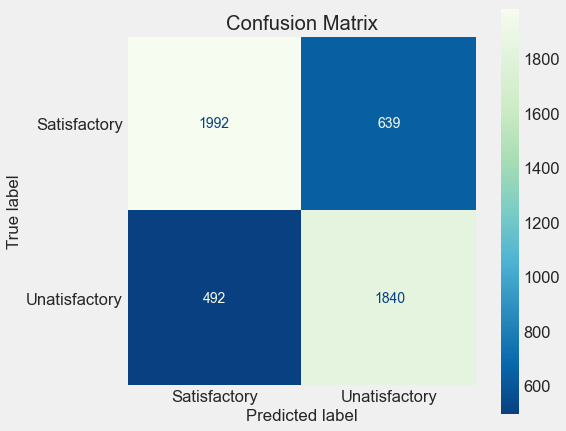

,Accuracy,F1,Recall,Precision
0,0.772114,0.764914,0.789022,0.742235


time: 12.1 s


In [153]:
%%capture --no-display
f.confusion_report(vc_svsi, X_test, y_test)

## Model Summary 3

In [154]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.694294,1.000000,0.531739,0.320701,Baseline DummyCFL
1,knn,0.547609,0.582077,0.592593,0.571965,9.371466,KNN
2,dt,0.550633,0.562221,0.542780,0.583205,1.117002,Decision Tree
3,bclf,0.551490,0.589040,0.604509,0.574372,7.211194,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.283309,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,14.178439,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.940607,XGBoost
7,fsm,0.591677,0.632245,0.660118,0.606662,0.318320,FSM Naive Bayes
8,svc,0.592876,0.639094,0.678690,0.604385,64.482871,Support Vector Classifier
9,logreg,0.595958,0.637900,0.669458,0.609299,3.004439,Logistic Regression


time: 11.8 ms


## Neural Network

### Create Model

In [155]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=38, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.48 ms


In [156]:
NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.14 ms


### Pipeline

In [157]:
nn_svsi = make_pipeline(preprocessing_mm, NN)

time: 1.15 ms


### Fitting Models

In [158]:
# %%capture --no-display
nn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1cf329a00>)])

time: 5.4 s


In [159]:
# f.pickle_model(nn_svsi, 'nn_svsi')

time: 713 µs


### Cross Val Scores

In [160]:
%%capture --no-display
modeling.report(nn_svsi, X_train, y_train, 'nn_svsi',\
                'Neural Net SVSI/MinMax()')

time: 23.3 s


### Test Data Confusion Matrix

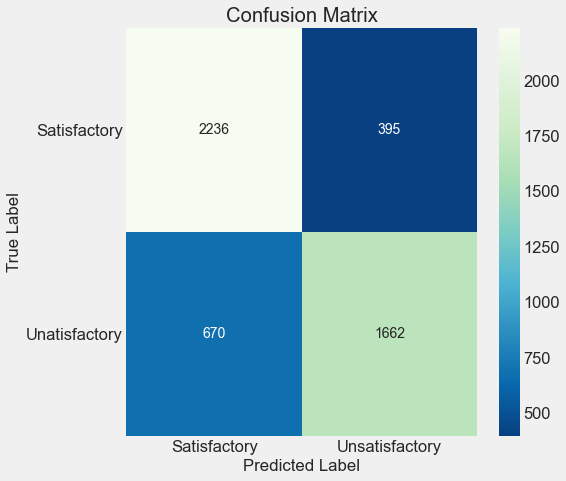

,Accuracy,F1,Recall,Precision
0,0.785412,0.757348,0.712693,0.807973


time: 719 ms


In [161]:
%%capture --no-display
f.confusion_report_nn(nn_svsi, X_test, y_test)

## Model Summary 4

In [162]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.694294,1.000000,0.531739,0.320701,Baseline DummyCFL
1,knn,0.547609,0.582077,0.592593,0.571965,9.371466,KNN
2,dt,0.550633,0.562221,0.542780,0.583205,1.117002,Decision Tree
3,bclf,0.551490,0.589040,0.604509,0.574372,7.211194,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.283309,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,14.178439,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.940607,XGBoost
7,fsm,0.591677,0.632245,0.660118,0.606662,0.318320,FSM Naive Bayes
8,svc,0.592876,0.639094,0.678690,0.604385,64.482871,Support Vector Classifier
9,logreg,0.595958,0.637900,0.669458,0.609299,3.004439,Logistic Regression


time: 12.3 ms


In [163]:
%%capture --no-display
# df = modeling.history
# f.df_plot(df, 'modeling_history')

time: 1.07 ms


# Adding Assessment Data Features
<font size=4>(mean_score, median_score, weighted_ave)</font>

In [164]:
# path = os.path.join(gparent, 'data/processed/df2.csv')
# df = pd.read_csv(path)

time: 757 µs


In [165]:
# df.info()

time: 688 µs


In [166]:
df = db.df_a()

time: 44.8 s


In [167]:
drops = ['row_id', 'code_module', 'code_presentation', 'sum_click', 'date',
         'id_student', 'id_site', 'studied_credits', 'final_result']

time: 714 µs


In [168]:
# %%capture --no-display
df = db.pipe_cleaner_wa(df, drops)

time: 89.7 ms


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22579 entries, 0 to 26330
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                22579 non-null  int64   
 1   gender                22579 non-null  object  
 2   region                22579 non-null  object  
 3   highest_education     22579 non-null  object  
 4   imd_band              22579 non-null  object  
 5   age_band              22579 non-null  object  
 6   num_of_prev_attempts  22579 non-null  int64   
 7   disability            22579 non-null  object  
 8   click_sum             22579 non-null  int64   
 9   num_activities        22579 non-null  int64   
 10  course_load           22579 non-null  category
 11  mean_score            22579 non-null  float64 
 12  median_score          22579 non-null  float64 
 13  weighted_ave          22579 non-null  float64 
dtypes: category(1), float64(3), int64(4), object(6)
memory

In [170]:
df.weighted_ave.describe()

count    22579.000000
mean        62.558422
std         47.311616
min          0.000000
25%         18.000000
50%         65.300000
75%         86.500000
max        195.640000
Name: weighted_ave, dtype: float64

time: 6.13 ms


## Creating Holdout Data

In [171]:
# splitting data & target
X, y = f.X_y(df)

time: 4.31 ms


In [172]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 13.5 ms


## Creating Training Data

In [173]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 9.89 ms


## Naive Bayes Classifier

In [174]:
mnb_assess = make_pipeline(preprocessing_mm, mnb)

time: 869 µs


### Fitting Model

In [175]:
mnb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('multinomialnb', MultinomialNB())])

time: 55.1 ms


### Saving Model

In [176]:
# f.pickle_model(mnb_assess, 'mnb_assess')

time: 639 µs


### Cross Val Scores

In [177]:
# checking cross val scores
modeling.report(mnb_assess, X_train, y_train, 'mnb_assess',\
                'Naive Bayes ASSESS/MinMax()')

mnb_assess has an average Accuracy of 0.6865354330708662
mnb_assess has an average F1 of 0.5720562024350198
mnb_assess has an average Recall of 0.4846994535519126
mnb_assess has an average Precision of 0.69787531235429
time: 289 ms


### Test Data Confusion Matrix

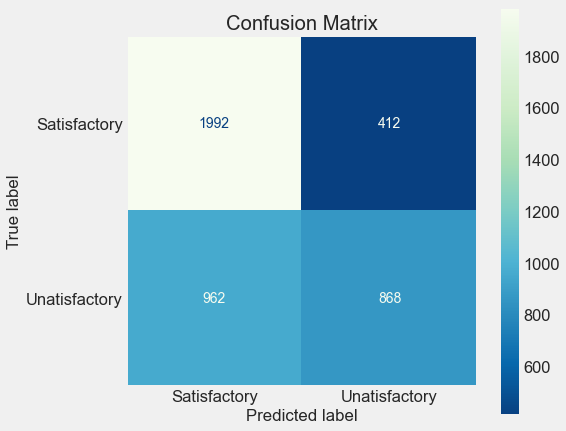

,Accuracy,F1,Recall,Precision
0,0.675484,0.558199,0.474317,0.678125


time: 227 ms


In [178]:
f.confusion_report(mnb_assess, X_test, y_test)

## KNeighborsClassifier

In [179]:
knn_assess = make_pipeline(preprocessing_mm, KNN)

time: 864 µs


### Fitting Model

In [180]:
knn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 52.6 ms


In [181]:
# f.pickle_model(knn_assess, 'knn_assess')

time: 655 µs


### Cross Val Scores

In [182]:
# checking cross val scores
modeling.report(knn_assess, X_train, y_train, 'knn_assess',\
                'KNN ASSESS/MinMax()')

knn_assess has an average Accuracy of 0.6948031496062993
knn_assess has an average F1 of 0.622513889469355
knn_assess has an average Recall of 0.5821493624772313
knn_assess has an average Precision of 0.6690014893045196
time: 5.57 s


### Test Data Confusion Matrix

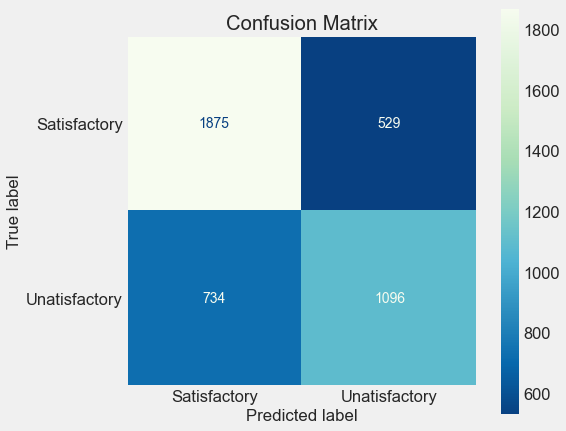

,Accuracy,F1,Recall,Precision
0,0.701701,0.634443,0.598907,0.674462


time: 11.4 s


In [183]:
f.confusion_report(knn_assess, X_test, y_test)

## Logistic Regression Classifier

In [184]:
logreg_assess = make_pipeline(preprocessing_mm, LR)

time: 820 µs


### Fitting Model

In [185]:
logreg_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 387 ms


In [186]:
# f.pickle_model(logreg_assess, 'logreg_assess')

time: 581 µs


### Cross Val Scores

In [187]:
# checking cross val scores
modeling.report(logreg_assess, X_train, y_train, 'logreg_assess',\
                'LogReg ASSESS/MinMax()')

logreg_assess has an average Accuracy of 0.7911023622047243
logreg_assess has an average F1 of 0.7559379279626353
logreg_assess has an average Recall of 0.7482695810564663
logreg_assess has an average Precision of 0.763810160081742
time: 952 ms


### Test Data Confusion Matrix

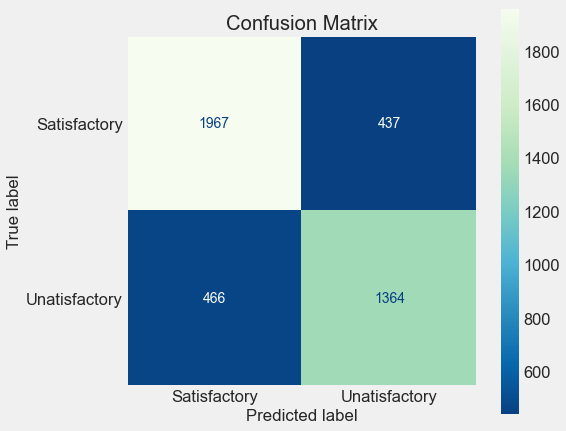

,Accuracy,F1,Recall,Precision
0,0.786726,0.751308,0.745355,0.757357


time: 220 ms


In [188]:
f.confusion_report(logreg_assess, X_test, y_test)

## Support Vector Machine

In [189]:
svc_assess= make_pipeline(preprocessing_mm, SVC)

time: 911 µs


### Fitting Model

In [190]:
svc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('svc', SVC())])

time: 6.37 s


In [191]:
# f.pickle_model(svc_assess, 'svc_assess')

time: 700 µs


### Cross Val Scores

In [192]:
# checking cross val scores
modeling.report(svc_assess, X_train, y_train, 'svc_assess',\
                'Support Vector CLF ASSESS/MinMax()')

svc_assess has an average Accuracy of 0.7951181102362206
svc_assess has an average F1 of 0.7553263440385154
svc_assess has an average Recall of 0.731511839708561
svc_assess has an average Precision of 0.780793365078701
time: 24.9 s


### Test Data Confusion Matrix

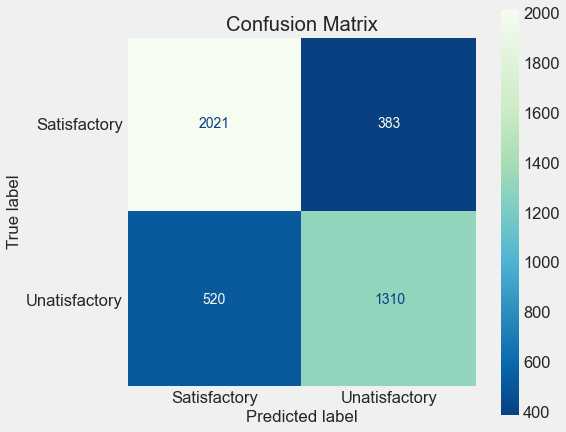

,Accuracy,F1,Recall,Precision
0,0.786726,0.743684,0.715847,0.773774


time: 7.28 s


In [193]:
f.confusion_report(svc_assess, X_test, y_test)

## Linear Support Vector Machine

In [194]:
lsvc_assess = make_pipeline(preprocessing_mm, LSVC)

time: 827 µs


### Fitting Model

In [195]:
lsvc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('linearsvc', LinearSVC())])

time: 191 ms


In [196]:
# f.pickle_model(lsvc_assess, 'lsvc_assess')

time: 583 µs


### Cross Val Scores

In [197]:
# checking cross val scores
modeling.report(lsvc_assess, X_train, y_train, 'lsvc_assess',\
                'Linear SVC ASSESS/MinMax()')

lsvc_assess has an average Accuracy of 0.7921259842519686
lsvc_assess has an average F1 of 0.7583972092769592
lsvc_assess has an average Recall of 0.7546448087431694
lsvc_assess has an average Precision of 0.7622386299250709
time: 914 ms


### Test Data Confusion Matrix

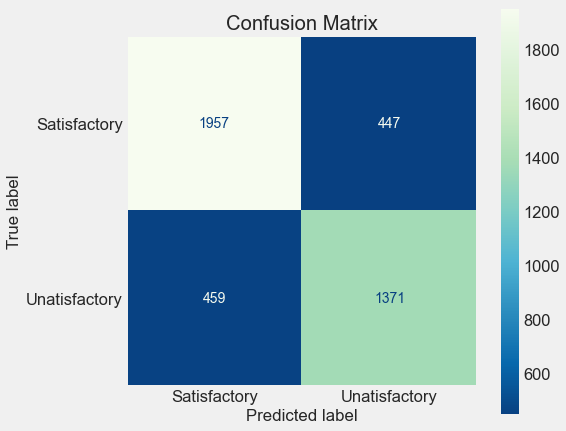

,Accuracy,F1,Recall,Precision
0,0.786018,0.751645,0.74918,0.754125


time: 211 ms


In [198]:
f.confusion_report(lsvc_assess, X_test, y_test)

## Decision Tree

In [199]:
dt_assess = make_pipeline(preprocessing_mm, DT)

time: 832 µs


### Fitting Model

In [200]:
dt_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 393 ms


In [201]:
# f.pickle_model(dt_assess, 'dt_assess')

time: 782 µs


### Cross Val Scores

In [202]:
# checking cross val scores
modeling.report(dt_assess, X_train, y_train, 'dt_assess',\
                'Decision Tree CLF ASSESS/MinMax()')

dt_assess has an average Accuracy of 0.8277165354330709
dt_assess has an average F1 of 0.8022213791262589
dt_assess has an average Recall of 0.8087431693989071
dt_assess has an average Precision of 0.7959979805431441
time: 1.53 s


### Test Data Confusion Matrix

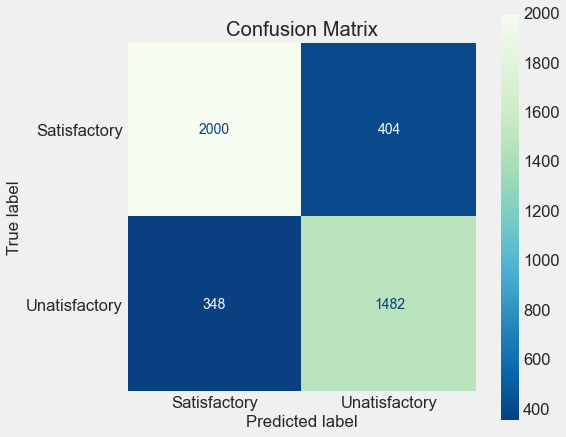

,Accuracy,F1,Recall,Precision
0,0.82239,0.797632,0.809836,0.78579


time: 238 ms


In [203]:
f.confusion_report(dt_assess, X_test, y_test)

## Bagging Classifier

In [204]:
bclf_assess = make_pipeline(preprocessing_mm, BCLF)

time: 915 µs


### Fitting Model

In [205]:
bclf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.28 s


In [206]:
# f.pickle_model(bclf_assess, 'bclf_assess')

time: 591 µs


### Cross Val Scores

In [207]:
# checking cross val scores
modeling.report(bclf_assess, X_train, y_train, 'bclf_assess',\
                'Bagging CLF ASSESS/MinMax()')

bclf_assess has an average Accuracy of 0.8690551181102361
bclf_assess has an average F1 of 0.838374843839189
bclf_assess has an average Recall of 0.785792349726776
bclf_assess has an average Precision of 0.8985650363343053
time: 8.23 s


### Test Data Confusion Matrix

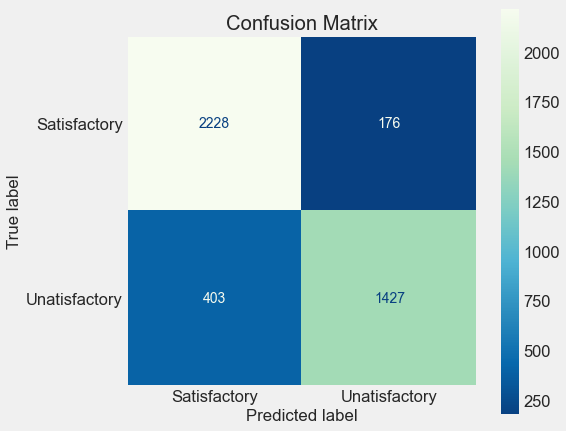

,Accuracy,F1,Recall,Precision
0,0.86325,0.831343,0.779781,0.890206


time: 260 ms


In [208]:
f.confusion_report(bclf_assess, X_test, y_test)

## Random Forest Classifier

In [209]:
rf_assess = make_pipeline(preprocessing_mm, RF)

time: 834 µs


### Fitting Model

In [210]:
rf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 1.74 s


In [211]:
# f.pickle_model(rf_assess, 'rf_assess')

time: 607 µs


### Cross Val Scores

In [212]:
# checking cross val scores
modeling.report(rf_assess, X_train, y_train, 'rf_assess',\
                'Random Forest ASSESS/MinMax()')

rf_assess has an average Accuracy of 0.868976377952756
rf_assess has an average F1 of 0.841824283125959
rf_assess has an average Recall of 0.8067395264116577
rf_assess has an average Precision of 0.8801972515960749
time: 8.37 s


### Test Data Confusion Matrix

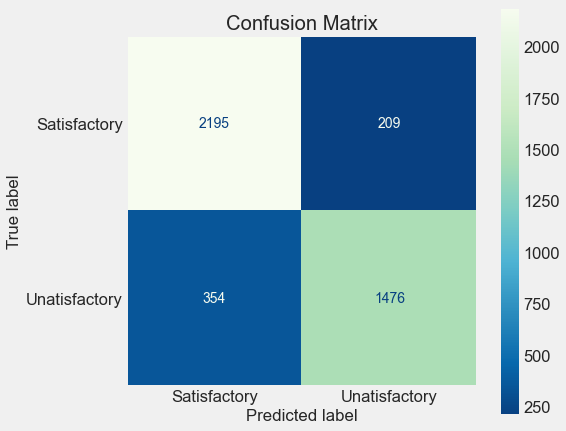

,Accuracy,F1,Recall,Precision
0,0.867029,0.839829,0.806557,0.875964


time: 437 ms


In [213]:
f.confusion_report(rf_assess, X_test, y_test)

## AdaBoost

In [214]:
ada_assess = make_pipeline(preprocessing_mm, ADA)

time: 906 µs


### Fitting Model

In [215]:
ada_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 433 ms


In [216]:
# f.pickle_model(ada_assess, 'ada_assess')

time: 674 µs


### Cross Val Scores

In [217]:
# checking cross val scores
modeling.report(ada_assess, X_train, y_train, 'ada_assess',\
                'AdaBoost ASSESS/MinMax()')

ada_assess has an average Accuracy of 0.8272440944881889
ada_assess has an average F1 of 0.8015262357552133
ada_assess has an average Recall of 0.8074681238615666
ada_assess has an average Precision of 0.7958654500688441
time: 1.54 s


### Test Data Confusion Matrix

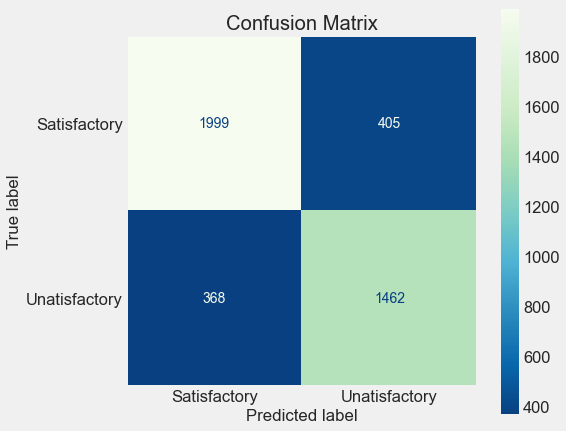

,Accuracy,F1,Recall,Precision
0,0.81743,0.790912,0.798907,0.783074


time: 219 ms


In [218]:
f.confusion_report(ada_assess, X_test, y_test)

## XGBoost

In [219]:
xgb_assess = make_pipeline(preprocessing_mm, XGB)

time: 842 µs


### Fitting Model

In [220]:
%%capture --no-display
xgb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.3 s


In [221]:
# f.pickle_model(xgb_assess, 'xgb_assess')

time: 851 µs


### Cross Val Scores

In [222]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_assess, X_train, y_train, 'xgb_assess',\
                'XGBoost ASSESS/MinMax()')

time: 6.33 s


### Test Data Confusion Matrix

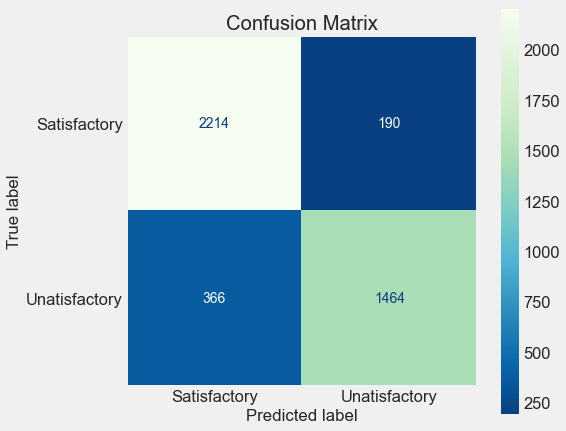

,Accuracy,F1,Recall,Precision
0,0.868682,0.840413,0.8,0.885127


time: 365 ms


In [223]:
%%capture --no-display
f.confusion_report(xgb_assess, X_test, y_test)

## Model Summary 5

In [224]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.694294,1.000000,0.531739,0.320701,Baseline DummyCFL
1,knn,0.547609,0.582077,0.592593,0.571965,9.371466,KNN
2,dt,0.550633,0.562221,0.542780,0.583205,1.117002,Decision Tree
3,bclf,0.551490,0.589040,0.604509,0.574372,7.211194,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.283309,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,14.178439,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.940607,XGBoost
7,fsm,0.591677,0.632245,0.660118,0.606662,0.318320,FSM Naive Bayes
8,svc,0.592876,0.639094,0.678690,0.604385,64.482871,Support Vector Classifier
9,logreg,0.595958,0.637900,0.669458,0.609299,3.004439,Logistic Regression


time: 14.2 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [225]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf', clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 988 µs


In [226]:
vc_assess = make_pipeline(preprocessing_mm, VC)

time: 846 µs


### Fitting Model

In [227]:
%%capture --no-display
vc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 4.79 s


In [228]:
# f.pickle_model(vc_assess, 'vc_assess')

time: 652 µs


### Cross Val Scores

In [229]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_assess, X_train, y_train, 'vc_assess',\
                'Voting CLF ASSESS/MinMax()')

time: 17.1 s


### Test Data Confusion Matrix

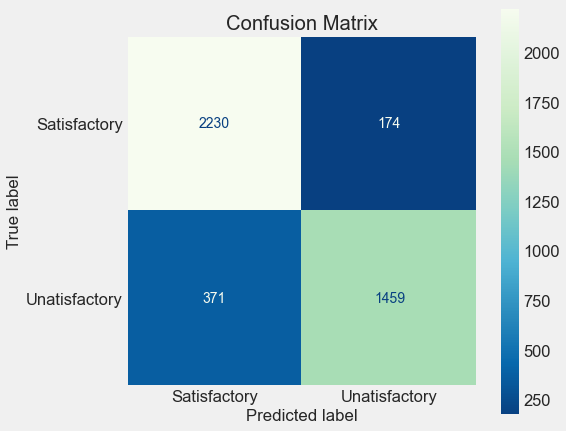

,Accuracy,F1,Recall,Precision
0,0.87128,0.842622,0.797268,0.893448


time: 828 ms


In [230]:
%%capture --no-display
f.confusion_report(vc_assess, X_test, y_test)

## Model Summary 6

In [231]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.694294,1.000000,0.531739,0.320701,Baseline DummyCFL
1,knn,0.547609,0.582077,0.592593,0.571965,9.371466,KNN
2,dt,0.550633,0.562221,0.542780,0.583205,1.117002,Decision Tree
3,bclf,0.551490,0.589040,0.604509,0.574372,7.211194,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.283309,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,14.178439,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.940607,XGBoost
7,fsm,0.591677,0.632245,0.660118,0.606662,0.318320,FSM Naive Bayes
8,svc,0.592876,0.639094,0.678690,0.604385,64.482871,Support Vector Classifier
9,logreg,0.595958,0.637900,0.669458,0.609299,3.004439,Logistic Regression


time: 15.5 ms


## Neural Network

In [232]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=41, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.1 ms


In [233]:
NN2 = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.04 ms


### Pipeline

In [234]:
nn_assess = make_pipeline(preprocessing_mm, NN2)

time: 919 µs


### Fitting Models

In [235]:
%%capture --no-display
nn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1844ab250>)])

time: 4.54 s


In [236]:
# f.pickle_model(nn_assess, 'nn_assess')

time: 678 µs


### Cross Val Scores

In [237]:
%%capture --no-display
modeling.report(nn_assess, X_train, y_train, 'nn_assess',\
                'Neural Net ASSESS/MinMax()')

time: 19.3 s


### Test Data Confusion Matrix

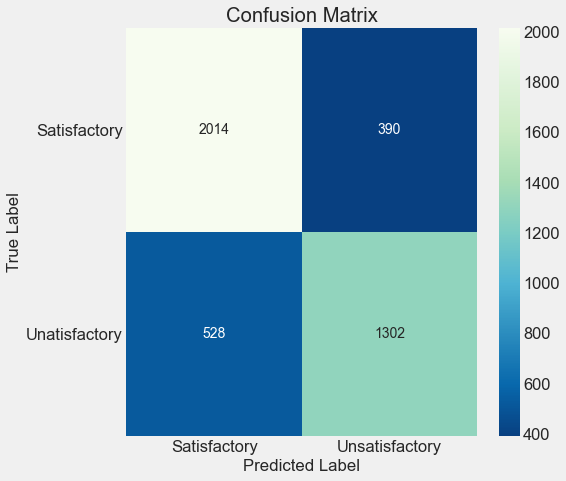

,Accuracy,F1,Recall,Precision
0,0.783184,0.739353,0.711475,0.769504


time: 639 ms


In [238]:
%%capture --no-display
f.confusion_report_nn(nn_assess, X_test, y_test)

## Model Summary 7

In [239]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.694294,1.000000,0.531739,0.320701,Baseline DummyCFL
1,knn,0.547609,0.582077,0.592593,0.571965,9.371466,KNN
2,dt,0.550633,0.562221,0.542780,0.583205,1.117002,Decision Tree
3,bclf,0.551490,0.589040,0.604509,0.574372,7.211194,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.283309,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,14.178439,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.940607,XGBoost
7,fsm,0.591677,0.632245,0.660118,0.606662,0.318320,FSM Naive Bayes
8,svc,0.592876,0.639094,0.678690,0.604385,64.482871,Support Vector Classifier
9,logreg,0.595958,0.637900,0.669458,0.609299,3.004439,Logistic Regression


time: 12.9 ms


# SS Test

## KNeighborsClassifier

In [240]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 942 µs


### Fitting Model

In [241]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 52.6 ms


In [242]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 697 µs


### Cross Val Scores

In [243]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7903937007874016
knn_ss has an average F1 of 0.7483930095135466
knn_ss has an average Recall of 0.7211293260473589
knn_ss has an average Precision of 0.7778498355442294
time: 5.42 s


### Test Data Confusion Matrix

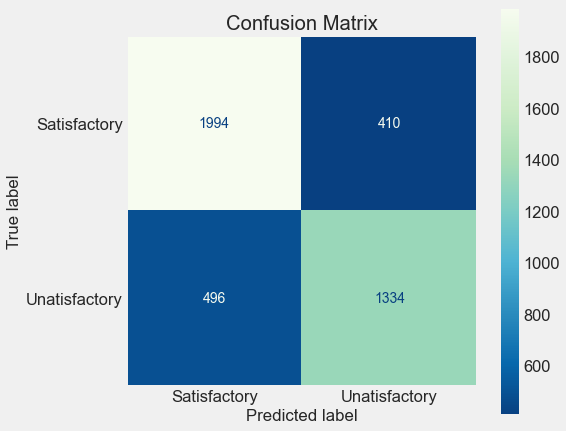

,Accuracy,F1,Recall,Precision
0,0.786018,0.746503,0.728962,0.764908


time: 11.4 s


In [244]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [245]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.03 ms


### Fitting Model

In [246]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 331 ms


In [247]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 536 µs


### Cross Val Scores

In [248]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7929921259842518
logreg_ss has an average F1 of 0.75864501281507
logreg_ss has an average Recall of 0.7524590163934425
logreg_ss has an average Precision of 0.7650172628729759
time: 621 ms


### Test Data Confusion Matrix

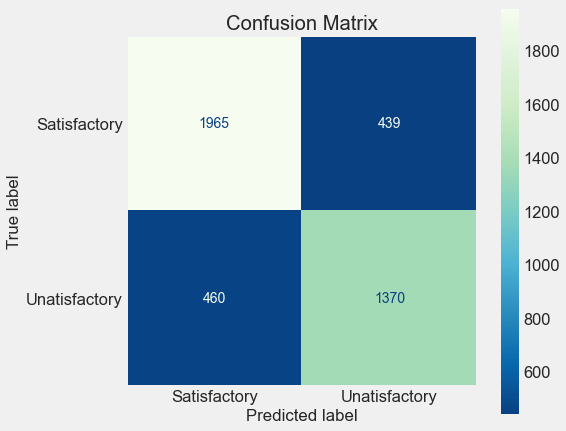

,Accuracy,F1,Recall,Precision
0,0.787671,0.752954,0.748634,0.757324


time: 210 ms


In [249]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [250]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 954 µs


### Fitting Model

In [251]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('svc', SVC())])

time: 5.46 s


In [252]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 662 µs


### Cross Val Scores

In [253]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.8284251968503937
svc_ss has an average F1 of 0.7950030534700916
svc_ss has an average Recall of 0.7695810564663024
svc_ss has an average Precision of 0.8222218442865434
time: 27.7 s


### Test Data Confusion Matrix

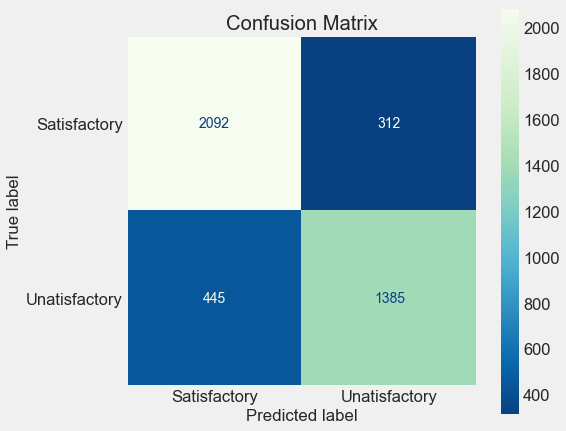

,Accuracy,F1,Recall,Precision
0,0.821209,0.78537,0.756831,0.816146


time: 6.39 s


In [254]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [255]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 875 µs


### Fitting Model

In [256]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('linearsvc', LinearSVC())])

time: 733 ms


In [257]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 600 µs


### Cross Val Scores

In [258]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7923622047244094
lsvc_ss has an average F1 of 0.7587830568079957
lsvc_ss has an average Recall of 0.7553734061930782
lsvc_ss has an average Precision of 0.7622875588424195
time: 2.89 s


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Test Data Confusion Matrix

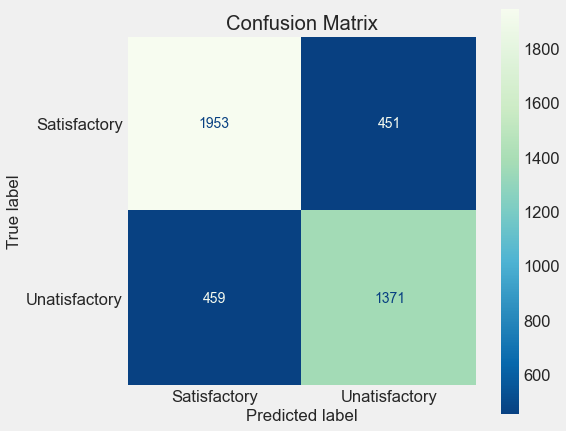

,Accuracy,F1,Recall,Precision
0,0.785073,0.750821,0.74918,0.75247


time: 271 ms


In [259]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [260]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 909 µs


### Fitting Model

In [261]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 419 ms


In [262]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 623 µs


### Cross Val Scores

In [263]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.8279527559055119
dt_ss has an average F1 of 0.8024053808929705
dt_ss has an average Recall of 0.8085610200364298
dt_ss has an average Precision of 0.7965412259496452
time: 1.63 s


### Test Data Confusion Matrix

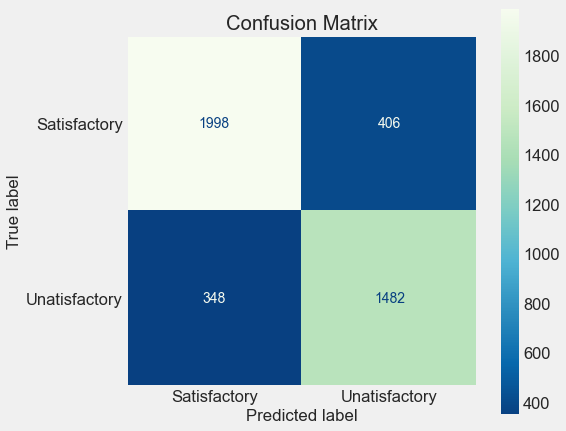

,Accuracy,F1,Recall,Precision
0,0.821918,0.797203,0.809836,0.784958


time: 264 ms


In [264]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [265]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 918 µs


### Fitting Model

In [266]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.41 s


In [267]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 670 µs


### Cross Val Scores

In [268]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.8690551181102363
bclf_ss has an average F1 of 0.8384417725985701
bclf_ss has an average Recall of 0.7861566484517304
bclf_ss has an average Precision of 0.8982379732413198
time: 8.8 s


### Test Data Confusion Matrix

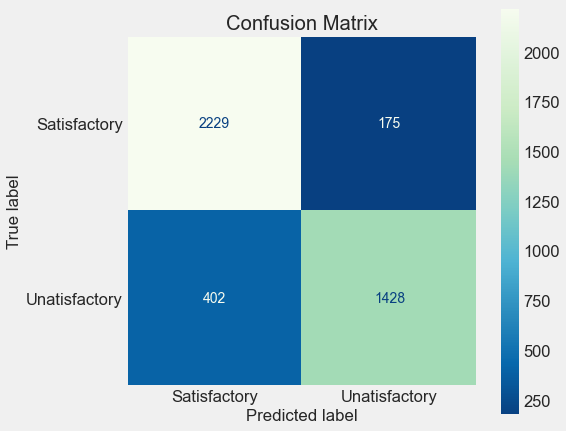

,Accuracy,F1,Recall,Precision
0,0.863722,0.831925,0.780328,0.89083


time: 309 ms


In [269]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [270]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 960 µs


### Fitting Model

In [271]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 1.87 s


In [272]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 834 µs


### Cross Val Scores

In [273]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.8688976377952755
rf_ss has an average F1 of 0.8416807641384978
rf_ss has an average Recall of 0.8063752276867031
rf_ss has an average Precision of 0.8803216697684787
time: 9.72 s


### Test Data Confusion Matrix

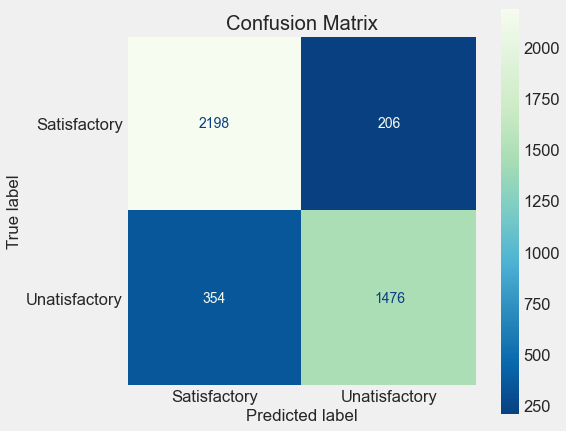

,Accuracy,F1,Recall,Precision
0,0.867737,0.840547,0.806557,0.877527


time: 476 ms


In [274]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [275]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 894 µs


### Fitting Model

In [276]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 434 ms


In [277]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 664 µs


### Cross Val Scores

In [278]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.8272440944881889
ada_ss has an average F1 of 0.8014247656025457
ada_ss has an average Recall of 0.8069216757741348
ada_ss has an average Precision of 0.7961835863036683
time: 1.57 s


### Test Data Confusion Matrix

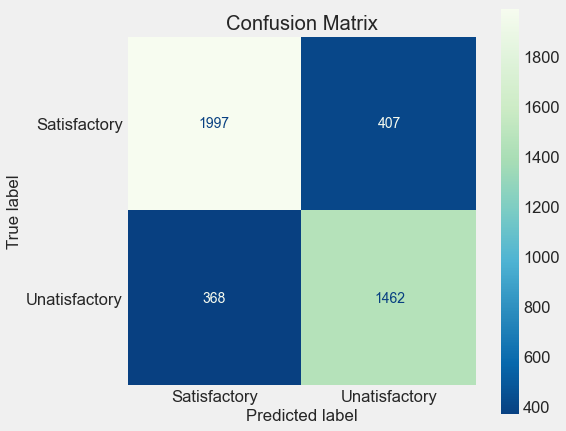

,Accuracy,F1,Recall,Precision
0,0.816958,0.790484,0.798907,0.782236


time: 242 ms


In [279]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [280]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 834 µs


### Fitting Model

In [281]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 920 ms


In [282]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 780 µs


### Cross Val Scores

In [283]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

time: 4.68 s


### Test Data Confusion Matrix

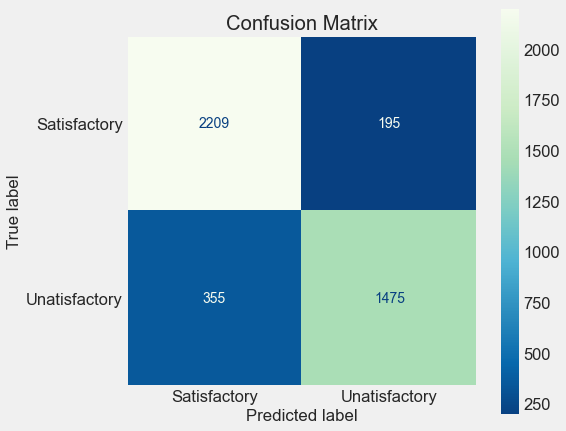

,Accuracy,F1,Recall,Precision
0,0.870099,0.842857,0.806011,0.883234


time: 497 ms


In [284]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary 8

In [285]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.694294,1.000000,0.531739,0.320701,Baseline DummyCFL
1,knn,0.547609,0.582077,0.592593,0.571965,9.371466,KNN
2,dt,0.550633,0.562221,0.542780,0.583205,1.117002,Decision Tree
3,bclf,0.551490,0.589040,0.604509,0.574372,7.211194,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.283309,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,14.178439,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.940607,XGBoost
7,fsm,0.591677,0.632245,0.660118,0.606662,0.318320,FSM Naive Bayes
8,svc,0.592876,0.639094,0.678690,0.604385,64.482871,Support Vector Classifier
9,logreg,0.595958,0.637900,0.669458,0.609299,3.004439,Logistic Regression


time: 28.3 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [286]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.3 ms


In [287]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 1.1 ms


### Fitting Model

In [288]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.22 s


In [289]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 584 µs


### Cross Val Scores

In [290]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

time: 19.2 s


### Test Data Confusion Matrix

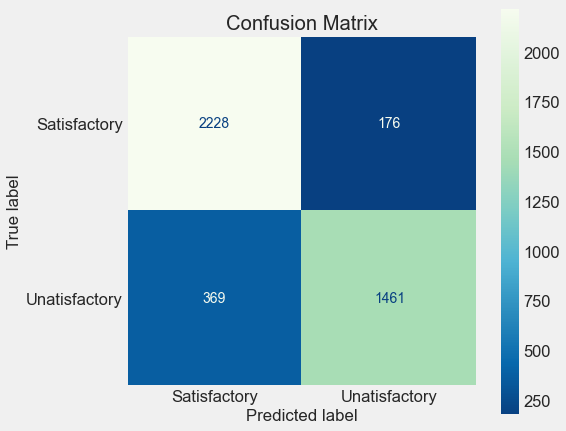

,Accuracy,F1,Recall,Precision
0,0.87128,0.842804,0.798361,0.892486


time: 841 ms


In [291]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary 9

In [292]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.694294,1.000000,0.531739,0.320701,Baseline DummyCFL
1,knn,0.547609,0.582077,0.592593,0.571965,9.371466,KNN
2,dt,0.550633,0.562221,0.542780,0.583205,1.117002,Decision Tree
3,bclf,0.551490,0.589040,0.604509,0.574372,7.211194,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.283309,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,14.178439,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.940607,XGBoost
7,fsm,0.591677,0.632245,0.660118,0.606662,0.318320,FSM Naive Bayes
8,svc,0.592876,0.639094,0.678690,0.604385,64.482871,Support Vector Classifier
9,logreg,0.595958,0.637900,0.669458,0.609299,3.004439,Logistic Regression


time: 21.1 ms


## Neural Network

### Pipeline

In [293]:
nn_ss = make_pipeline(preprocessing_ss, NN2)

time: 836 µs


### Fitting Models

In [294]:
%%capture --no-display
nn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc520>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10a8dc820>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1844ab250>)])

time: 4.57 s


In [295]:
# f.pickle_model(nn_ss, 'nn_ss')

time: 660 µs


### Cross Val Scores

In [296]:
%%capture --no-display
modeling.report(nn_ss, X_train, y_train, 'nn_ss',\
                'Neural Net SS()')

time: 21.2 s


### Test Data Confusion Matrix

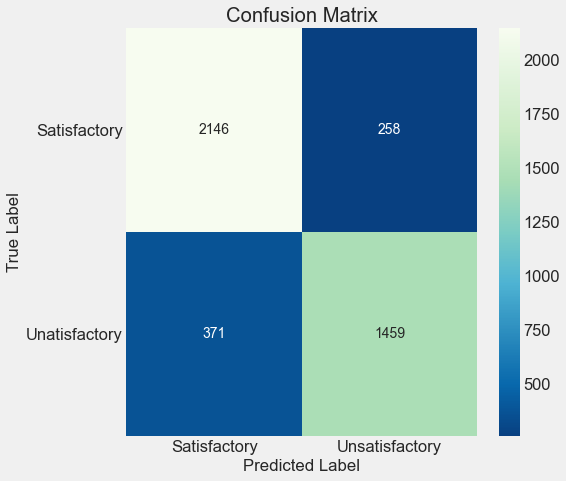

,Accuracy,F1,Recall,Precision
0,0.851441,0.822667,0.797268,0.849738


time: 634 ms


In [297]:
%%capture --no-display
f.confusion_report_nn(nn_ss, X_test, y_test)

## Model Summary 10

In [298]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.531739,0.694294,1.000000,0.531739,0.320701,Baseline DummyCFL
1,knn,0.547609,0.582077,0.592593,0.571965,9.371466,KNN
2,dt,0.550633,0.562221,0.542780,0.583205,1.117002,Decision Tree
3,bclf,0.551490,0.589040,0.604509,0.574372,7.211194,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.283309,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,14.178439,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.940607,XGBoost
7,fsm,0.591677,0.632245,0.660118,0.606662,0.318320,FSM Naive Bayes
8,svc,0.592876,0.639094,0.678690,0.604385,64.482871,Support Vector Classifier
9,logreg,0.595958,0.637900,0.669458,0.609299,3.004439,Logistic Regression


time: 18 ms


In [299]:
Audio(sound_file, autoplay=True)

time: 7.42 ms


In [301]:
%%capture --no-display
# ma_df = modeling.history
# f.df_plot(ma_df, 'modeling_history')

[0804/202145.419411:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/zd/kv0c241x5x109jjq38dprq6h0000gn/T/: Operation not permitted (1)
[0804/202145.421805:ERROR:file_io.cc(91)] ReadExactly: expected 8, observed 0
[0804/202145.424090:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/zd/kv0c241x5x109jjq38dprq6h0000gn/T/: Operation not permitted (1)
[0804/202147.064295:INFO:headless_shell.cc(648)] Written to file /var/folders/zd/kv0c241x5x109jjq38dprq6h0000gn/T/tmpaof1kxa3/temp.png.
[0804/202147.468633:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/zd/kv0c241x5x109jjq38dprq6h0000gn/T/: Operation not permitted (1)
[0804/202147.470398:ERROR:file_io.cc(91)] ReadExactly: expected 8, observed 0
[0804/202147.472933:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/zd/kv0c241x5x109jjq38dprq6h0000gn/T/: Operation not permit

time: 7.08 s
[20:18:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:13:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to resto